In [1]:
#importing necessary libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
import category_encoders as ce
gc.enable()

### Importing and taking a look at the data

In [134]:
#importing and splitting the data into training and testing sets
df = pd.read_csv('wfp_food_prices_phl.csv')
df.head()

C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (4,5,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+type,#currency,#value,#value+usd
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,PHP,15.0,0.3
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.35,0.36
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,PHP,16.35,0.32
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,"meat, fish and eggs",Meat (pork),KG,actual,PHP,105.37,2.09


In [135]:
df.shape

(87752, 13)

In [136]:
df.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'pricetype', 'currency', 'price',
       'usdprice'],
      dtype='object')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87752 entries, 0 to 87751
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       87752 non-null  object
 1   admin1     87752 non-null  object
 2   admin2     87752 non-null  object
 3   market     87752 non-null  object
 4   latitude   87752 non-null  object
 5   longitude  87752 non-null  object
 6   category   87752 non-null  object
 7   commodity  87752 non-null  object
 8   unit       87752 non-null  object
 9   pricetype  87752 non-null  object
 10  currency   87752 non-null  object
 11  price      87752 non-null  object
 12  usdprice   87752 non-null  object
dtypes: object(13)
memory usage: 8.7+ MB


In [138]:
df['pricetype'].value_counts()

actual              82744
aggregate            5007
#item+price+type        1
Name: pricetype, dtype: int64

In [139]:
df['commodity'].value_counts()

Rice (regular, milled)    3944
Meat (pork)               3787
Tomatoes                  3252
Carrots                   3200
Cabbage                   3169
                          ... 
Meat (pork, with fat)      156
Oil (cooking)              133
Garlic (small)              84
Chicken                     68
#item+name                   1
Name: commodity, Length: 74, dtype: int64

### Preperation of the Data

In [140]:
#Removing the index rows
df = df.drop(labels=[0], axis=0)
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,PHP,15.0,0.3
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.35,0.36
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,PHP,16.35,0.32
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,"meat, fish and eggs",Meat (pork),KG,actual,PHP,105.37,2.09
5,2000-01-15,Region III,Nueva Ecija,Palayan,15.5415,121.0848,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.0,0.36


Based from the observations in the data, the relevant factors here in predicting the price are the location(market), category, and commodity. S we will extract those columns from the dataset.

In [141]:
#extracting the feature variables and making their type as category
features = df[['market', 'category', 'commodity']]
for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features[c] = features[c].astype('category')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87751 entries, 1 to 87751
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   market     87751 non-null  category
 1   category   87751 non-null  category
 2   commodity  87751 non-null  category
dtypes: category(3)
memory usage: 950.4 KB


<ipython-input-141-5c5be06ad116>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[c] = features[c].astype('category')


In [142]:
#extrecting the price and converting its type into float64
price = df[['price']]
price = price.astype(float)
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87751 entries, 1 to 87751
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   87751 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


In [143]:
#Creating the train test dataset
data_train, data_test, price_train, price_test = train_test_split(features,price, test_size=0.5, random_state=14, stratify=features[['commodity']])

In this case, the 'data_train' and 'price train' are used to train the model and the 'data_test and 'price_test' are used to measure the accuracy and overfitting of the model.

### Implementing LightGBM

In [144]:
#preparing the train data
X_train, X_test, y_train, y_test = train_test_split(data_train, price_train, test_size = 0.2, random_state = 14, stratify=data_train[['commodity']])

In [145]:
#lightgbm model
clf = lgb.LGBMRegressor(num_leaves= 14, max_depth = 17, 
                         random_state = 314, 
                         silent = True,
                         objective = 'regression',
                         categorical_feature = ['market', 'category', 'commodity'],
                         metric = 'auc', 
                         device_type = 'cpu',
                         n_estimators = 2000,
                         colsample_bytree = 0.9,
                         subsample = 0.8,
                         bagging_freq = 7,
                         learning_rate = 0.1, 
                       )

In [146]:
clf.fit(X_train, y_train, eval_set = [(X_test,y_test)],eval_metric = 'l1', early_stopping_rounds = 2000)

C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python3

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l1: 64.2067	valid_0's auc: 1
[2]	valid_0's l1: 58.617	valid_0's auc: 1
[3]	valid_0's l1: 53.6365	valid_0's auc: 1
[4]	valid_0's l1: 49.1857	valid_0's auc: 1
[5]	valid_0's l1: 45.2869	valid_0's auc: 1
[6]	valid_0's l1: 41.8345	valid_0's auc: 1
[7]	valid_0's l1: 38.7839	valid_0's auc: 1
[8]	valid_0's l1: 36.1287	valid_0's auc: 1
[9]	valid_0's l1: 33.8042	valid_0's auc: 1
[10]	valid_0's l1: 31.7579	valid_0's auc: 1
[11]	valid_0's l1: 29.9691	valid_0's auc: 1
[12]	valid_0's l1: 28.4359	valid_0's auc: 1
[13]	valid_0's l1: 27.0959	valid_0's auc: 1
[14]	valid_0's l1: 25.9654	valid_0's auc: 1
[15]	valid_0's l1: 24.902	valid_0's auc: 1
[16]	valid_0's l1: 24.0456	valid_0's auc: 1
[17]	valid_0's l1: 23.2441	valid_0's auc: 1
[18]	valid_0's l1: 22.6076	valid_0's auc: 1
[19]	valid_0's l1: 22.0596	valid_0's auc: 1
[20]	valid_0's l1: 21.5825	valid_0's auc: 1
[21]	valid_0's l1: 21.1

LGBMRegressor(bagging_freq=7,
              categorical_feature=['market', 'category', 'commodity'],
              colsample_bytree=0.9, device_type='cpu', max_depth=17,
              metric='auc', n_estimators=2000, num_leaves=14,
              objective='regression', random_state=314, silent=True,
              subsample=0.8)

In [147]:
#Getting the RMSE
y_pred = clf.predict(X_train)
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.19687


In [148]:
#Testing the model for the untouched data ('price_test') and getting its rmse
y_pred_t = clf.predict(data_test)
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred_t, price_test) ** 0.5, 5))

The rmse of prediction is: 0.22012


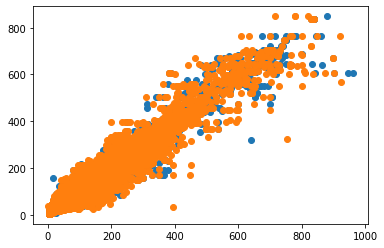

In [149]:
#Generating the scatterplot of the train data and the test data
mat=plt.scatter(y_train, y_pred)
mat_test=plt.scatter(price_test, y_pred_t)